In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm.auto import tqdm

In [2]:
os.chdir("../src")

In [3]:
from models import IBModel, DecayModel
from subjects_data import read_all, preprocess_data
from config import halflife_vals
from utils import BETA_STR

In [4]:
PATH = os.path.join(os.path.expanduser("~"), "proj_university\seminar-bci\subject_data")

In [5]:
data = read_all(PATH)
data = preprocess_data(data)

  0%|          | 0/17 [00:00<?, ?it/s]

Exception in HLA:
All arrays must be of the same length


#### IB N and $\beta$ in subjects (As given by previous paper results)

In [6]:
print(f"Num of subjects: {data['name'].nunique()}")
print(f"Num of different N: {data['N'].nunique()}")
print(f"Num of different betas: {data['beta_ind'].nunique()}")
data.groupby('name')[['N', 'beta']].first().T

Num of subjects: 16
Num of different betas: 6
Num of different N: 12


name,AT,CK,ES,EW,GG,IG,LV,MH,MN,MZ,RS,SG,SM,SN,YF,ZD
N,42.0,10.000000,9.000000,41.000000,20.000000,41.000000,12.0,19.000000,40.000000,15.0,42.000000,27.000000,15.000000,42.0,18.000000,16.0
beta,100.0,2.636651,48.329302,14.384499,2.636651,61.584821,100.0,2.636651,2.636651,100.0,2.636651,4.281332,2.636651,100.0,48.329302,100.0


#### Fitting Models

In [7]:
subject_models = dict()
for name in tqdm(data['name'].unique()):
    sequence = data.loc[data["name"]==name, "block"].astype(np.int32)
    auc_normal = data.loc[data["name"]==name, "auc_normal"]
    N = data.loc[data['name']==name, 'N'].unique().item()
    beta = data.loc[data['name']==name, 'beta'].unique().item()
    
    if auc_normal.isnull().any():
        auc_normal = auc_normal.interpolate(method="linear")
    
    best_decay_model = None
    best_r2 = -1
    for tau in halflife_vals:
        decay_model = DecayModel(tau)
        decay_model.fit(response=auc_normal, sequence=sequence)
        r2 = decay_model.score(decay_model.explanatory_variables(sequence), auc_normal[1:])
        if r2 > best_r2:
            best_decay_model = decay_model
            best_r2 = r2
    
    ib_model = IBModel(N, beta)
    ib_model.fit()
    
    subject_models[name] = {"decay": best_decay_model, "IB": ib_model}
    
    print(f"{name}\tbest r2: {best_r2:.3f}\t best tau: {best_decay_model.tau}\t IB (N, {BETA_STR}): " +
          f"({N},{beta:.3f})")
    

  0%|          | 0/16 [00:00<?, ?it/s]

AT	best r2: 0.134	 best tau: 1	 IB (N, β): (42,100.000)
CK	best r2: 0.205	 best tau: 2	 IB (N, β): (10,2.637)
ES	best r2: 0.047	 best tau: 2	 IB (N, β): (9,48.329)
EW	best r2: 0.091	 best tau: 1	 IB (N, β): (41,14.384)
GG	best r2: 0.170	 best tau: 1	 IB (N, β): (20,2.637)
IG	best r2: 0.083	 best tau: 1	 IB (N, β): (41,61.585)
LV	best r2: 0.050	 best tau: 1	 IB (N, β): (12,100.000)
MH	best r2: 0.065	 best tau: 4	 IB (N, β): (19,2.637)
MN	best r2: 0.166	 best tau: 1	 IB (N, β): (40,2.637)
MZ	best r2: 0.160	 best tau: 1	 IB (N, β): (15,100.000)
RS	best r2: 0.027	 best tau: 8	 IB (N, β): (42,2.637)
SG	best r2: 0.135	 best tau: 16	 IB (N, β): (27,4.281)
SM	best r2: 0.251	 best tau: 2	 IB (N, β): (15,2.637)
SN	best r2: 0.065	 best tau: 1	 IB (N, β): (42,100.000)
YF	best r2: 0.021	 best tau: 50	 IB (N, β): (18,48.329)
ZD	best r2: 0.180	 best tau: 1	 IB (N, β): (16,100.000)


#### Computing Surprise Predictors

In [20]:
def plot_surprise_vs_auc(name):
    sequence = data.loc[data["name"]==name, "block"].astype(np.int32)
    auc_normal = data.loc[data["name"]==name, "auc_normal"]
    N = data.loc[data['name']==name, 'N'].unique().item()
    beta = data.loc[data['name']==name, 'beta'].unique().item()
    
    fig, axs = plt.subplots(1, 2)
    for ax, model_name in zip(axs, ["decay", "IB"]):
        model = subject_models[name][model_name]
        surprise = model.surprise_predictor(sequence)
        title = f"{name} tau={model.tau}" if model_name=="decay" else f"{name} N={N}, {BETA_STR}={beta:.2f}"
        
        pd.concat([auc_normal, pd.Series(surprise,name="surprise")], axis=1).plot(
            kind="scatter", x="surprise", y="auc_normal", title=title, ax=ax, figsize=(15,5))

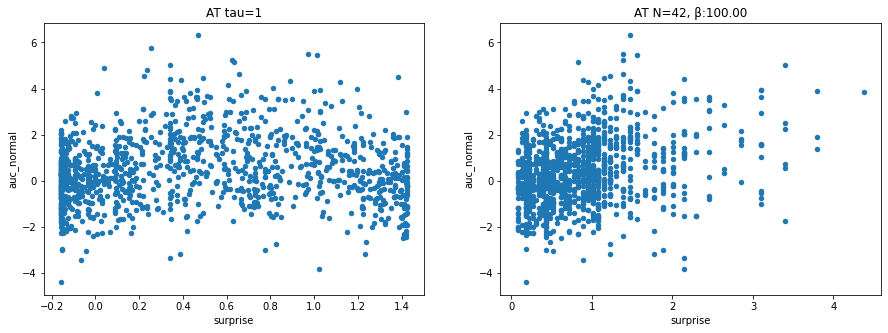

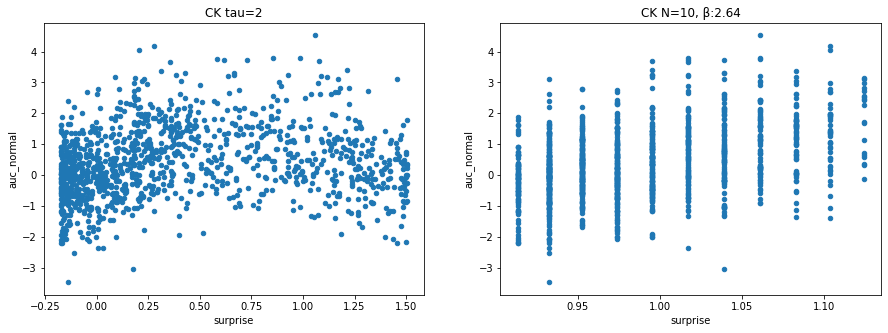

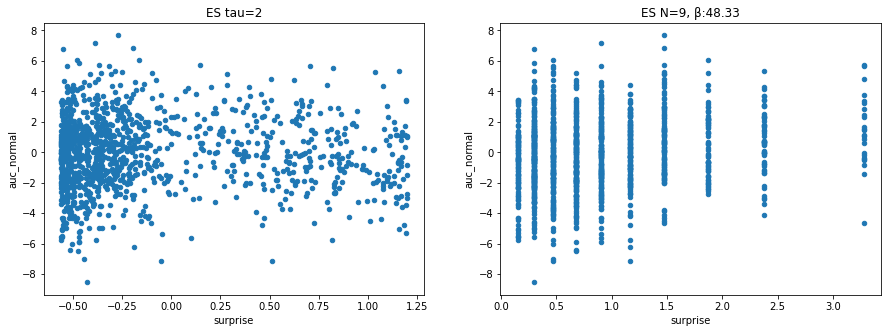

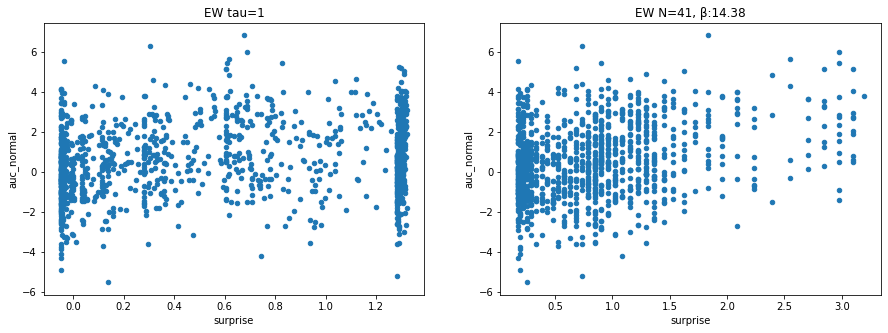

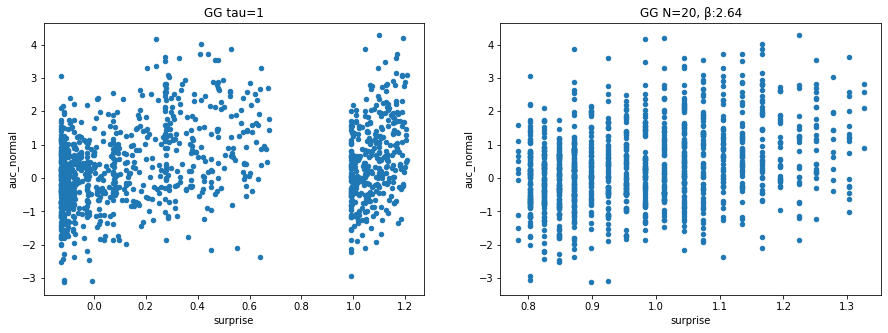

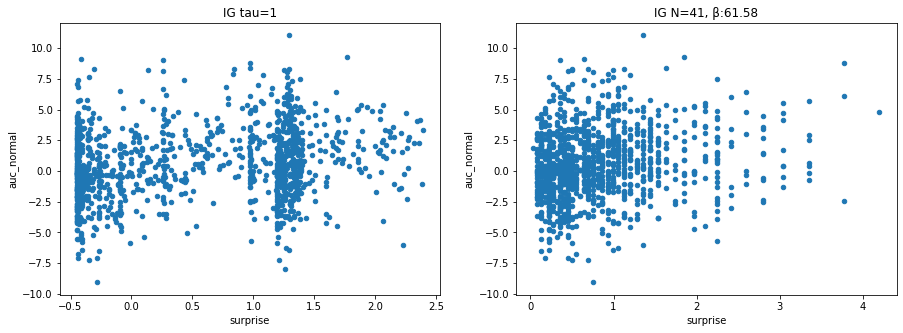

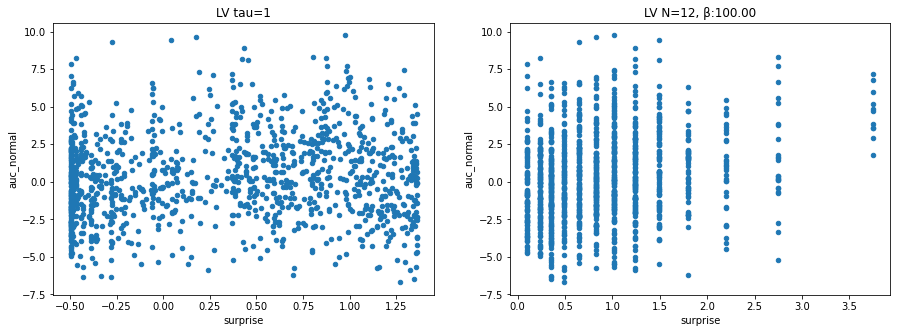

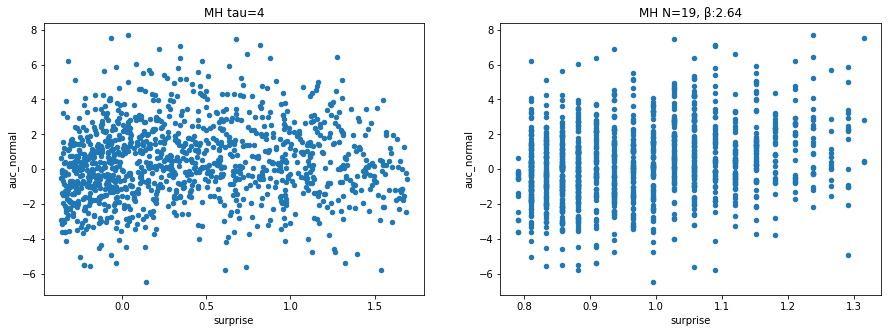

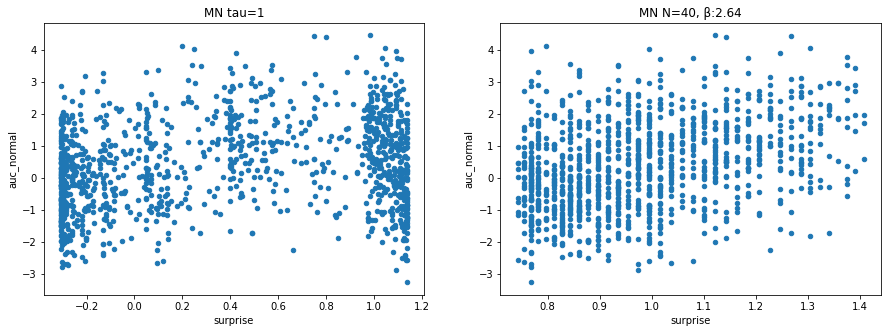

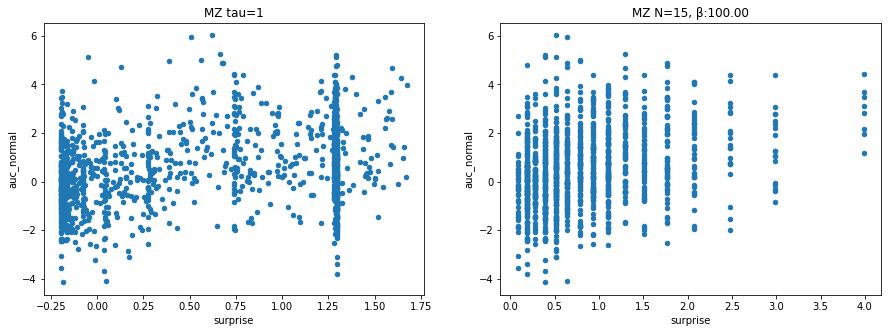

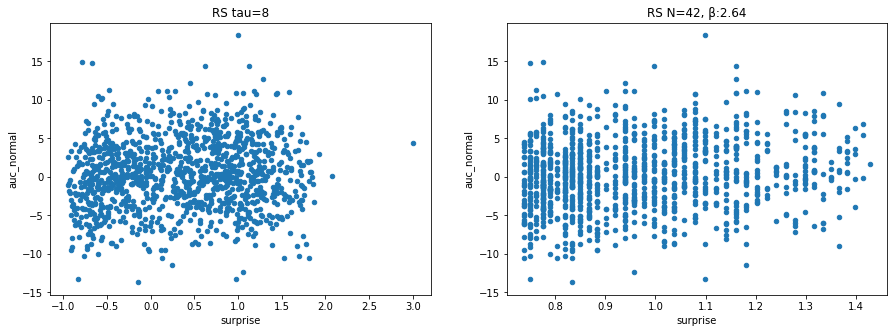

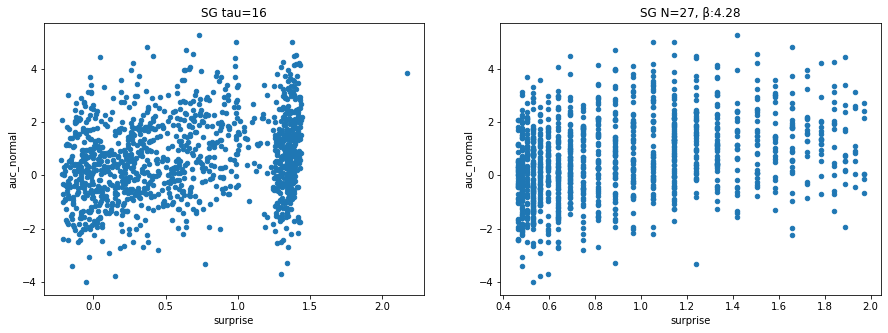

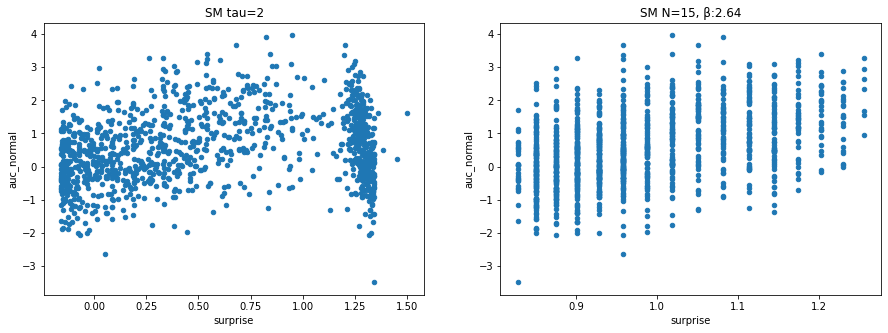

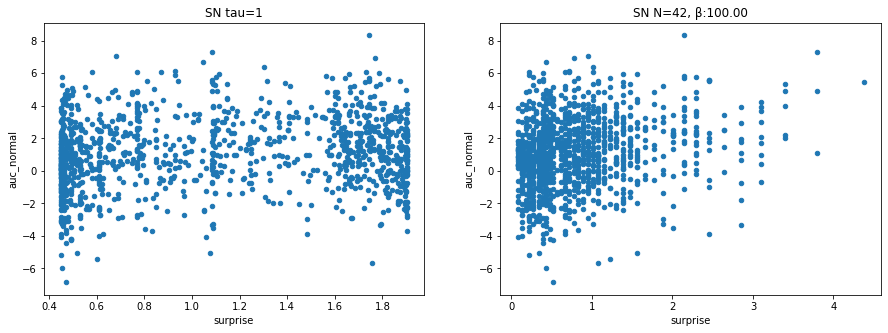

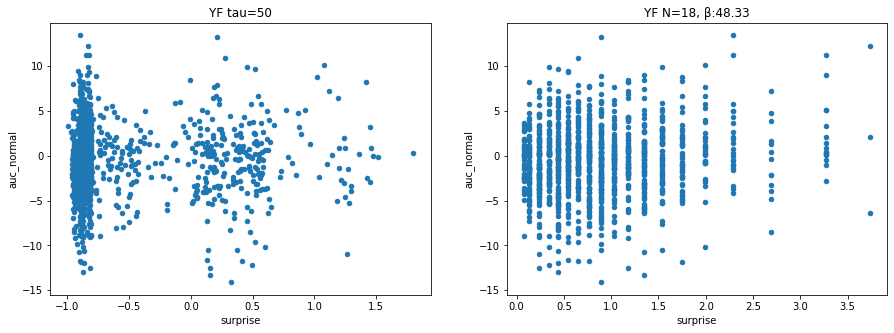

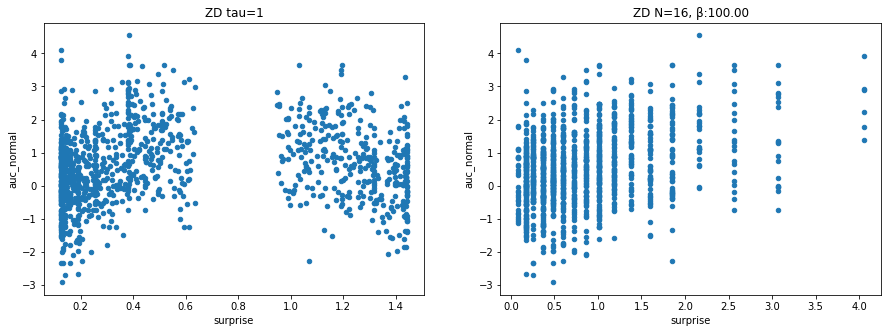

In [22]:
for name in data["name"].unique():
    plot_surprise_vs_auc(name)

In [11]:
subject_models['SG']['decay'].tau

16